<a href="https://colab.research.google.com/github/shubhamnawani99/sentiment-analysis-tensorflow/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Training

## Import


In [0]:
import json
import tensorflow as tf
import numpy as np
import io
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

##Pre-Processing

In [0]:
path_musical = "/Musical_Instruments_5.json"
#path = "/Cell_Phones_and_Accessories_5.json"
filepath = "model.h5"
vocab_size = 10000 
embedding_dim = 24
max_length = 60 
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 5000

In [0]:
with open(path_musical, 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['reviewText'])
    labels.append(item['overall'])

## Sequences and padding

In [0]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


## Convolutional Neural Network Layers

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.4),                       #to avoid overfitting
    tf.keras.layers.Dense(24, activation='relu'),     
    tf.keras.layers.Dense(6, activation='softmax')   
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 24)            240000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                14592     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 150       
Total params: 256,302
Trainable params: 256,302
Non-trainable params: 0
_________________________________________________________________


##Processing

In [10]:
num_epochs = 5                                    #epoch set as 5 to demonstate the working of the neural network
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

Epoch 1/2
157/157 [==============================] - 7s 46ms/step - loss: 0.7508 - accuracy: 0.7028 - val_loss: 0.9902 - val_accuracy: 0.6330
Epoch 2/2
157/157 [==============================] - 7s 44ms/step - loss: 0.6309 - accuracy: 0.7504 - val_loss: 1.0375 - val_accuracy: 0.6546
(10000, 24)


##Testing vs Validation Accuracy


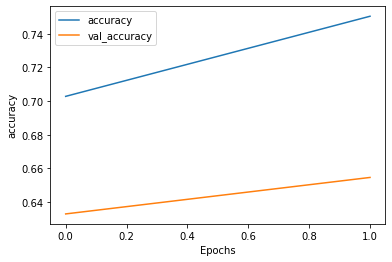

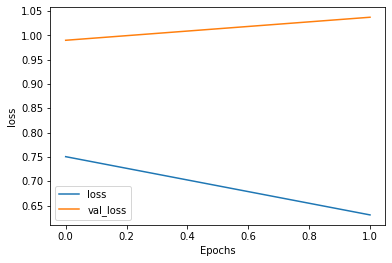

In [11]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

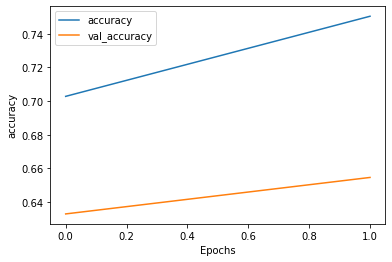

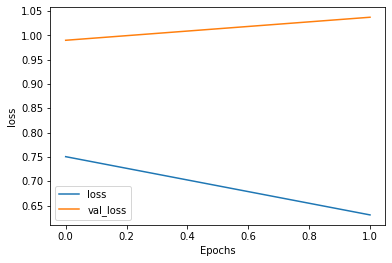

In [27]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history,'accuracy')
plot_graphs(history,'loss')

model.save(filepath)

#Prediction
This program uses the model trained above to determine the rating of the feedback.

##Pre-Process

In [0]:
path = "/Musical_Instruments_5.json"
filepath = "model.h5"
vocab_size = 10000
embedding_dim = 24
max_length = 60
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 5000

##Prediction Model

In [0]:
with open(path, 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['reviewText'])

training_sentences = sentences[0:training_size]
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

model = tf.keras.models.load_model(filepath)

##Feedback Classification

In [30]:
i=0; average = 0; ch = 'y'
while(ch == 'y'):
    temp = input('Enter the feedback: ')
    stock = [temp]
    data = tokenizer.texts_to_sequences(stock)
    data_padded = pad_sequences(data, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    data = np.array(data_padded)
    classes = model.predict(data)
    y_classes = classes.argmax(axis=-1)
    print('The feedback is rated:',y_classes[0])
    i = i+1
    average = ((i-1)/(i)*average) + (y_classes/i)
    ch = input('Continue?(y/n): ')
print('The overall product rating is %.1f' %average[0])

Enter the feedback: The product was amazing
The feedback is rated: 5
Continue?(y/n): y
Enter the feedback: The product is really good
The feedback is rated: 5
Continue?(y/n): y
Enter the feedback: The product was bad
The feedback is rated: 5
Continue?(y/n): y
Enter the feedback: worst
The feedback is rated: 3
Continue?(y/n): n
The overall product rating is 4.5
